In [1]:
!pip install celluloid

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve, norm #, inv, eigsh

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rc

#rc('text', usetex=False) # para usar latex en matplotlib

from celluloid import Camera #pip install celluloid si es que no lo tienen.

*Universidad de Chile*  
*Facultad de Ciencias Físicas y Matemáticas*  
*Departamento de Ingeniería Matemática*

**MA5307-1 Análisis Numérico de EDP: Teoría y Laboratorio**  
**Profesor:** Axel Osses  
**Auxiliares:** Emir Chacra

# Laboratorio 3

El objetivo de esta sesión es aplicar el método de diferencias finitas en varias variables para problemas de primer orden. Para ello, se estudiará la ecuación de advección de primer orden y la ecuación de Burgers, un modelo no lineal que permite modelar el tráfico vehicular.

## Ecuación de Advección

Sea un intervalo acotado $\Omega=\left(  a,b\right)  \subseteq\mathbb{R}$ y $\alpha>0$. Considere la el problema de advección de primer orden dado por 
$$
\begin{equation}
\left.
\begin{array}
[c]{rll}
\dfrac{\partial u}{\partial t}+\alpha\dfrac{\partial u}{\partial x}= &
0 & \qquad \text{para }\left(  t,x\right)  \in\mathbb{R}^{+}\times\Omega\\
u\left(  0,x\right)  = & u_{0}\left(  x\right)  & \qquad \text{para }x\in\Omega
\end{array}
\right\} \qquad (1)
\end{equation}
$$

Existen varios esquemas numéricos basados en diferencias finitas para analizar esta ecuación, pero tienen diversas particularidades. Elegir uno de ellos por sobre otro es una tarea difícil.

Sean $\Delta t>0$ y $N\in\mathbb{N}$. Definiendo $t_{n}=n\Delta t$ para $n\in\mathbb{N} \cup \left\{  0\right\}  $, $\Delta x=\dfrac{b-a}{N+1}$ y $x_{j}=a+j\Delta x$, para $j\in\{0,1,\ldots,N+1\}$; se denota $u_{j}^{n} = u\left(  t_{n},x_{j}\right)$. Los esquemas de tipo Lax son algunos de los más usados para resolver este tipo de problemas, siendo los más simples los esquemas de Lax-Friedrichs y de Lax-Wendroff, dados por

**a.** Lax-Friedrichs
$$
\dfrac{2u_{j}^{n+1}-\left(  u_{j+1}^{n}+u_{j-1}^{n}\right)  }{2\Delta
t}+\alpha\dfrac{u_{j+1}^{n}-u_{j-1}^{n}}{2\Delta x}=0
$$


**b.** Lax-Wendroff
$$
\dfrac{u_{j}^{n+1}-u_{j}^{n}}{\Delta t}+\alpha\dfrac{u_{j+1}^{n}-u_{j-1}^{n}%
}{2\Delta x}-\alpha^{2}\Delta t\dfrac{u_{j+1}^{n}-2u_{j}^{n}+u_{j-1}^{n}%
}{2\Delta x^2}=0
$$

### Ejercicio 1

Sean $\alpha,T>0$. Considere el siguiente problema
$$
\begin{array}{rll}
\displaystyle{\frac{\partial u}{\partial t}+\alpha\frac{\partial u}{\partial x}}  &
=0 & \qquad\text{para }\left(  t,x\right)  \in(0,T)\times\left(  0,1\right) \\
u(t,x+1)  &  =u(t,x) & \qquad\text{para }\left(  t,x\right)  \in\lbrack
0,T)\times\left[  0,1\right] \\
u\left(  0,x\right)   &  =u_{0}(x) & \qquad\text{para }x\in\left[  0,1\right]
\end{array}
$$

**a.** Programe una función que resuelva numéricamente esta ecuación por cada uno de los esquemas numéricos presentados anteriormente. Las entradas de cada programa deben ser $\alpha$, $\Delta t$, $N_{T}$, $N$ y $u_{0}$, donde $N_{T}$ es un entero tal que $N_{T}\Delta t=T$.

In [5]:
def resolver_adveccion(a, b, alpha, dt, NT, N, u0, esquema):
    """Resuelve la ecuacion de adveccion $\partial_t u + \alpha \partial_x u = 0$
    con condiciones periodicas, en el dominio (a,b) y un intervalo de tiempo [0,T].
    -------
    Input:
    - a: float
        Extremo izquierdo del dominio
    - b: float > a
        Extremo derecho del dominio
    - alpha: float
    - dt: float
        paso temporal para el que se resolvera la ecuacion
    - NT: int
        Cumple NT * dt = T
    - N: int
        Cantidad de subintervalos en que se discretizara el dominio. El paso espacial sera 1/N.
    - u0: callable
        Funcion con la condicion inicial del problema
    - esquema: {'LW', 'LF'}
        Esquema usado para resolver la ecuacion.
        - 'LW': Lax Wendroff
        - 'LF': Lax Friedrich
    -------
    Output:
    - x: numpy array, largo N+1
        Discretizacion del dominio donde se calculo la solucion
    - U: numpy array de (N+1)x(NT+1)
        Solucion, evaluada en la grilla en cada paso de tiempo. U[j,n] es la solucion en x_j, 
        en el tiempo t = n*dt.
    -------
    """
    e = np.ones(N+2) #Este comando define un vector de largo n lleno de 1's. Existe también np.zeros.
    f = np.ones(N+1)
    dx = (b-a)/(N+1)
    if esquema == "LW":
        lambda_ = alpha*dt/dx
        
        a0 = (1-lambda_**2)
        a1 = 0.5*lambda_*(lambda_-1)
        a_1 = 0.5*lambda_*(lambda_+1)

        k = np.array([a1, a_1*f,a0*e,a1*f, a_1], dtype= object) 
        offset = [-(N+1), -1,0,1, N+1]
        A_LW = diags(k,offset)

        x = [a+i*dx for i in range(N+2)]
        U = np.zeros((N+2, NT+1))
        
        U[:, 0] = u0
        ut_1 = u0
        for nt in range(1, NT+1):
            print(nt)
            ut = A_LW@ut_1
            ut_1 = ut
            U[:, nt] = ut
    elif esquema== "LF":
        a0 = 0
        a1 = 0.5 - dt*0.5*alpha/dx
        a_1 = 0.5 + dt*0.5*alpha/dx
        print(a_1, a0, a1)

        k = np.array([a1, a_1*f,a0*e,a1*f, a_1], dtype= object) 
        offset = [-(N+1), -1,0,1, N+1]
        A_LW = diags(k,offset)

        x = [a+i*dx for i in range(N+2)]
        U = np.zeros((N+2, NT+1))
        print(len(u0))
        U[:, 0] = u0
        ut_1 = u0
        for nt in range(1, NT+1):
            print(nt)
            ut = A_LW@ut_1
            ut_1 = ut
            U[:, nt] = ut
        

    return x, U

**b.** Considere $\Delta x=0.01$, $\alpha=1$, $\Delta t = \frac{\lambda}{\alpha}\Delta x$, $T=2$ y la condición inicial $u_{0}\left(  x\right)  =\sin\left(  2\pi x\right)  $. Calcule la solución numérica para $\lambda\in\left\{  0.8,0.4,0.1\right\}  $ y, para cada valor de $\lambda$, grafique las soluciones numéricas de cada método junto con la solución exacta.

Discuta los resultados en función de $\lambda$ y del tipo de
ecuación equivalente asociada a cada esquema.

**Indicación:** Utilice animaciones para observar la evolución de las soluciones.

In [6]:
params = {"dx": 0.01, "alpha": 1, "T":2, "lambda": [0.8, 0.4, 0.1]}

ULF_lambda = {str(l): None for l in params["lambda"]}
ULW_lambda = {str(l): None for l in params["lambda"]}

dt = params["dx"]*params["lambda"][0]/params["alpha"]
NT = int(params["T"]/dt)
N = int(1/params["dx"] - 1)
u0= [np.sin(2*np.pi*n*dt) for n in range(N+2)]

x, U = resolver_adveccion(0, 1, params["alpha"], dt, NT, N, u0, "LF")
ULF_lambda["0.8"] = U

ULW_lambda["0.8"] = resolver_adveccion(0, 1, params["alpha"], dt, NT, N, u0, "LW")[1]


0.9 0 0.09999999999999998
101
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [7]:
def animar_soluciones(x,ULF, ULW, UUW, alpha, dt, NT, N, u, file_name):
    """
    --------
    Input:
    - x: array
        Discretizacion de [0,1]
    - ULF, ULW, UUW: array
        Soluciones obtenidas con `resolver_adveccion` con los metodos LF, LW y UW respect.
    - u: callable
        Funcion que entrega la solucion real de la ecuacion.
    --------
    """
    
    fig = plt.figure(figsize = (10,5))
    #Definir parámetros de la figura
    
    #Inicializar animacion
    camera = Camera(fig)
    U = ULF
    #Comenzar a graficar
    for n in range(NT+1):
        #Graficos
        plt.plot(U[:,n], color="tab:blue");
        #Toma foto
        plt.title(file_name)
        camera.snap()
        
    
    #Exportar animaciones
    anim = camera.animate(blit=False, interval=100)
    name_gif = f'discretizacion_{file_name}.gif'
    anim.save(name_gif, writer='Pillow', fps=10);
    return name_gif

MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.


'discretizacion_LW_0.8.gif'

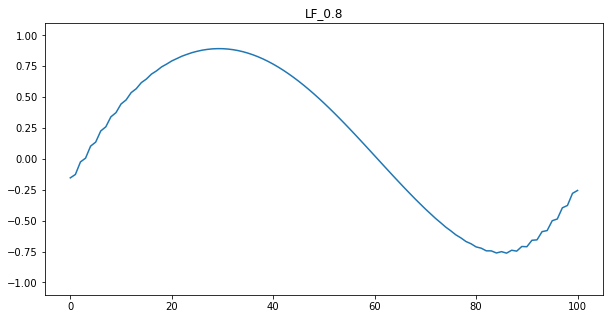

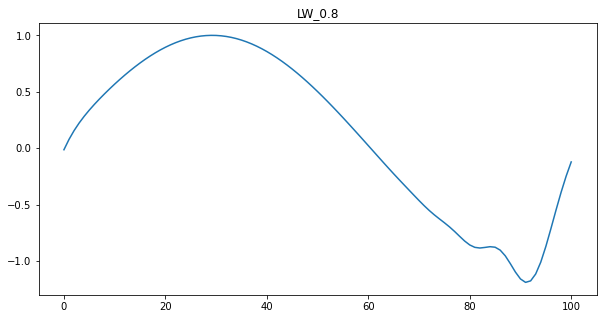

In [9]:
ULF = ULF_lambda["0.8"]
animar_soluciones(x,ULF, None, None, params["alpha"], dt, NT, N, None, "LF_0.8")
ULW = ULW_lambda["0.8"]
animar_soluciones(x,ULW, None, None, params["alpha"], dt, NT, N, None, "LW_0.8")

Lax-F
<img src='discretizacion_LF_0.8.gif' width="750" align="center">

Lax-W
<img src='discretizacion_LW_0.8.gif' width="750" align="center">

**c.** Repita lo anterior, considerando ahora la condición inicial
$$
u_{0}\left(  x\right)  =\left\{
\begin{array}
[c]{cl}
1/2 & \text{si }x\in\left[  0.3,0.7\right]  \\
-1/2 & \text{si }x\in\left[  0,1\right]  \setminus [  0.3,0.7]
\end{array}
\right.
$$

**Indicación.** Considere una extensión periódica de $u_{0}$, la cual puede ser útil para graficar la solución real.

## Ecuación de Burgers aplicado al tráfico vehicular

Uno de los problemas más complicados en la ingeniería de transporte es modelar el funcionamiento de los semáforos. Un modelo continuo para el tráfico vehicular en una única pista, donde no se permite adelantar un automóvil, está dado por la ecuación de Burgers. Asuma que la velocidad máxima está dada por $V$ y la densidad de vehículos por unidad de longitud está dada por $D>0$. Si la velocidad $v$ y la densidad $\rho$ se relacionan mediante la ley
$$
v=V\left(  1-\dfrac{\rho}{D}\right)  \qquad \text{ para }\rho\in\left[
0,D\right]
$$
y se define $u=1-\dfrac{2\rho}{D}$, se puede probar que se cumple la ecuación dada por
$$
\begin{equation}
\left.
\begin{array}
[c]{rll}
\dfrac{\partial u}{\partial t}+u\dfrac{\partial u}{\partial x}= &
0 & \qquad \text{para }\left(  t,x\right)  \in\mathbb{R}^{+}\times\Omega\\
u\left(  0,x\right)  = & u_{0}\left(  x\right)  & \qquad \text{para }x\in\Omega
\end{array}
\right\} \qquad (2)
\end{equation}
$$
donde $-1\leq u\leq1$. El valor $u=-1$ significa que los vehículos no se mueven, pues se llegó a la densidad máxima, mientras que el valor $u=1$ representa que un vehículo que pase por la vía puede ir a la velocidad máxima permitida, puesto que la vía está totalmente vacía.

A diferencia de la primera ecuación analizada en este laboratorio, no es posible obtener una forma explícita para la solución de la ecuación de Burgers, aunque puede probarse que
$$
u\left(  t,x\right)  =u_{0}\left(  x-u\left(  t,x\right)  t\right)
$$
es una expresión implícita para la solución. Además, esta ecuación es no lineal, por lo que aplicar los mismos esquemas antes estudiados requiere un estudio más profundo.

Otra forma de escribir esta ecuación es
$$
\begin{equation}
\left.
\begin{array}
[c]{rll}
\dfrac{\partial u}{\partial t}+\dfrac{\partial}{\partial x}\left[  \dfrac
{1}{2}u^{2}\right]  = & 0 &\qquad \text{ para }\left(  t,x\right)  \in
\mathbb{R}^{+}\times\Omega\\
u\left(  0,x\right)  = & u_{0}\left(  x\right) &\qquad \text{ para }x\in\Omega
\end{array}
\right\} \qquad (3)
\end{equation}
$$

la cual se conoce como forma conservativa de la ecuación de Burgers. Esta forma es sumamente útil para presentar los esquemas de Lax-Friedrichs y Lax-Wendroff aplicados para esta ecuación. En general, dichos esquemas se presentan para ecuaciones de la forma $\dfrac{\partial u}{\partial t}+\dfrac{\partial}{\partial x}\left[  f\left(  u\right)  \right] =0$.

Definiendo $\lambda=\dfrac{\Delta t}{\Delta x}$ y $f_{j}^{n}=f(
u_{j}^{n})  $, se presentan los esquemas de Lax-Friedrichs y
Lax-Wendroff en su forma conservativa

$1)$ Lax Friedrichs conservativo:

    1) Paso 1:
$$
F_{j}^{n} = \frac{1}{2}(f_{j-1}^n + f_j^n) - \frac{1}{2\lambda}(u_j^n - u_{j-1}^n)
$$

    2) Paso 2:
$$
u_j^{n+1} = u_j^n - \lambda (F_{j+1}^n - F_j^n)
$$

$2)$ Lax-Wendroff conservativo (esquema de Richtmyer)
Es posible demostrar que estos esquemas son consistentes y convergentes, con
los mismos órdenes que en el caso lineal.

    1) Paso 1:
$$
u_{j+1/2}^n = \frac{1}{2}(u_{j+1}^n + u_j^n) - \frac{\lambda}{2}(f_{j+1}^n - f_j^n)
$$
$$
u_{j-1/2}^n = \frac{1}{2}(u_{j}^n + u_{j-1}^n) - \frac{\lambda}{2}(f_{j}^n - f_{j-1}^n)
$$

    2) Paso 2:
$$
u_{j}^{n+1} =u_{j}^{n}-\lambda\left(  f\left(  u_{j+1/2}^{n}\right)-f\left(  u_{j-1/2}^{n}\right)  \right)
$$

A continuación se simulará el efecto de un flujo de vehículos que entra a una calle a una velocidad mayor a la que tienen otros vehículos que circulan más adelante.

## Ejercicio 2

Sea $f$ una función de clase $\mathcal{C}^{1}$, $T>0$ y $a,b\in\mathbb{R}$, con $a<b$. Considere la ecuación.
$$
\begin{array}{rll}
\dfrac{\partial u}{\partial t}+\dfrac{\partial}{\partial x}\left[  f\left(
u\right)  \right]   &  =0 & \qquad\text{para }\left(  t,x\right)  \in
(0,T)\times\left(  a,b\right)  \\
u\left(  t,a\right)   &  =u_{a} & \qquad\text{para }t\in\left(  0,T\right]  \\
u\left(  t,b\right)   &  =u_{b} & \qquad\text{para }t\in\left(  0,T\right]  \\
u\left(  0,x\right)   &  =u_{0}(x) & \qquad\text{para }x\in\left[  0,1\right]
\end{array}
$$

**a.** Implemente cada uno de los esquemas de Lax para resolver numéricamente esta ecuación mediante una función. Las entradas de cada programa deben ser la función $f$, $a$, $b$, las condiciones de frontera $u_{a}$ y $u_{b}$, $\Delta t>0$, $N_{T}\in\mathbb{N}$ tal que $N_{T}\Delta t=T$, $N\in\mathbb{N}$ como la cantidad de puntos interiores en su particion del intervalo $\left[  a,b\right]  $ y la condición inicial $u_{0}$ como un vector $\boldsymbol{u}_{0}=\left(  u_{j}^{0}\right)  \in\mathbb{R}^{N+2}$.

In [ ]:
def resolver_ej2(f, a, b, ua, ub, dt, N_T, N, u0, esquema):
    if esquema == 'LF':
        F = np.zeros((N+2,N_T))
        u = np.zeros((N+2,N_T))  
        for n in range(N_T):
            u[0][n] = ua
            u[N+1][n] = ub
        dx = (b-a)/(N+1)
        x = np.array([a+j*dx for j in range(N+2)])
        lambda_ = dt/dx
        for j in range(1,N+1):
            u[j][0] = u0(a+j*dx)
        for n in range(N_T-1):
            F[1][n] = 0.5*(f(u[0][n])+f(u[1][n]))- (0.5/lambda_)*(u[1][n]-u[0][n])
            for j in range(1,N+1):
                F[j+1][n] = 0.5*(f(u[j][n])+f(u[j+1][n]))- (0.5/lambda_)*(u[j+1][n]-u[j][n])
                u[j][n+1] = u[j][n] - lambda_*(F[j+1][n]-F[j][n])
                
    if esquema == 'LW':
        F = np.zeros((N+2,N_T))
        u = np.zeros((N+2,N_T))  
        for n in range(N_T):
            u[0][n] = ua
            u[N+1][n] = ub
        dx = (b-a)/(N+1)
        x = np.array([a+j*dx for j in range(N+2)])
        lambda_ = dt/dx
        for j in range(1,N+1):
            u[j][0] = u0(a+j*dx)
        for n in range(N_T-1):
            F[1][n] = 0.5*(u[0][n]+u[1][n]) - 0.5*lambda_*(f(u[1][n])-f(u[0][n]))
            for j in range(1,N+1):
                F[j+1][n] = 0.5*(u[j][n]+u[j+1][n]) - 0.5*lambda_*(f(u[j+1][n])-f(u[j][n]))
                u[j][n+1] = u[j][n] - lambda_*(f(F[j+1][n])-f(F[j][n]))
    return x, u


**b.** Considere el dominio $\Omega=\left[  0,1\right]  $, $D=1$, las condiciones de frontera $u\left(  t,0\right)  =0.5$ y $u\left(  t,1\right)  =0$ para todo $t>0$ y la condición inicial dada por
$$
u_{0}\left(  x\right)  =\left\{
\begin{array}
[c]{cc}%
0.5 & \text{si }x<0.2\\
0 & \text{si }x\geq0.2
\end{array}
\right.
$$
Resuelva numéricamente la ecuación de Burgers para este caso usando los esquemas conservativos de Lax-Friedrichs y Lax-Wendroff para $T=2$, $\Delta x\in\left\{  0.01,0.005,0.002\right\}  $ y $\Delta t=0.5\Delta x$. Grafique la velocidad y densidad apropiadamente.

In [ ]:
f = lambda x: 0.5*(x**2)
a, b = 0, 1
ua = 0.5
ub = 0
u0 = lambda x: 0.5 if x<0.2 else 0
dx = 0.01
dt = 0.5*dx
T = 2
N_T = int(T/dt)
N = int((b-a)/dx -1)

print(N, N_T)

x, U = resolver_ej2(f, a, b, ua, ub, dt, N_T, N, u0, "LW")

In [ ]:
def animar_soluciones_ej2(x,ULF, ULW, dt, NT, N, file_name):
    """
    --------
    Input:
    - x: array
        Discretizacion de [0,1]
    - ULF, ULF: array
        Soluciones obtenidas con `resolver_ej2` con los metodos LFy LW respect.
    --------
    """
    
    fig = plt.figure(figsize = (10,5))
    #Definir parámetros de la figura
    
    #Inicializar animacion
    camera = Camera(fig)
    
    U = ULF
    #Comenzar a graficar
    for n in range(NT):
        #Graficos
        plt.plot(U[:,n], color="tab:blue");
#         plt.xticks(range(N+2), x)
        #Toma foto
#         plt.title(file_name)
        camera.snap()
        
    
    #Exportar animaciones
    anim = camera.animate(blit=False, interval=100)
    name_gif = f'discretizacion_{file_name}.gif'
    anim.save(name_gif, writer='Pillow', fps=10);
    return name_gif

In [ ]:
animar_soluciones_ej2(x,U, None, dt, NT, N, "LW_0.01")

Lax-F
<img src='discretizacion_LF_0.01.gif' width="750" align="center">
Lax-W
<img src='discretizacion_LW_0.01.gif' width="750" align="center">

Ahora, se modelará el efecto de un semáforo en rojo, el cual cambiará a verde en un par de segundos. Para ello, considere que el tramo de vía a modelar es el intervalo $\left[ 0,2\right] $.

Si existe un semáforo en $x=1$, nuestro dominio de interés para modelar el efecto de la luz roja mediante la ecuación de Burgers será el intervalo $\left[  0,1\right]  $. Suponga que los autos entran por $x=0$ a una velocidad constante, la cual se representará por $u\left(  t,0\right)  =u^{\ast}$. Por otra parte, los vehículos deben detenerse frente al semáforo, por lo que
$u(t,1)=-1$.

Además, se asume que todos los vehículos circulaban a una velocidad inicial constante $u\left(  0,x\right)  =u^{\ast}$ hasta que ven el semáforo en rojo. En el instante $t=T$ en que el semáforo cambia a verde, la densidad de vehículos es nula en $\omega_{2}=\left(  1,2\right]  $. Luego, $u(T,x)=1$, para $x\in\omega_{2}$.

### Ejercicio 3
Simule el efecto del semáforo que cambia de color rojo a verde.


**a.** Resuelva numéricamente la ecuación de Burgers para $t\in\left[0,2\right]  $ en el dominio $\omega_{1}=\left[  0,1\right]  $, considerando la condición inicial
$$
u\left(  0,x\right)  =\left\{
\begin{array}
[c]{cl}%
u^{\ast} & \text{si }0\leq x<1\\
-1 & \text{si }x=1
\end{array}
\right.
$$
y las condiciones de frontera $u\left(  t,0\right)  =u^{\ast}$ y $u(t,1)=-1$, con $u^{\ast}=0.25$. Para ello, use el esquema de Lax-Friedrichs con $\Delta x=0.002$ y $\Delta t=0.1\Delta x$, simulando un semáforo en rojo que dure $T=2$.


**b.** Resuelva numéricamente la ecuación de Burgers para $t\in\left[2,4\right]  $ y $\Omega=\omega_{1}\cup\omega_{2}=\left[  0,2\right]  $, considerando las condiciones de frontera $u\left(  t,0\right)  =u^{\ast}$ y $u(t,2)=1$, y la condición inicial dada por
$$
u\left(  2,x\right)  =\left\{
\begin{array}
[c]{cl}%
u_{R}\left(  2,x\right)   & \text{si }0\leq x\leq1\\
1 & \text{si }x>1
\end{array}
\right.
$$
donde $u_{R}\left(  2,x\right)  $ es la solución numérica resultante en el ejercicio anterior. Use los mismos parámetros y esquema que la parte anterior y grafique su solución solo en el conjunto $\omega_1$.

**c.** Interprete los resultados